Proyek Analisis Sentimen

Ahmad Sabil Deva Pratama

devapratama4912@gmail.com

In [1]:
!pip install deep_translator -q
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Import Library

In [9]:
import pandas as pd
import numpy as np
import re
import string
import time
import nltk
import spacy
nltk.download('stopwords')
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud

from textblob import TextBlob
from deep_translator import GoogleTranslator

from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read Data

In [3]:
df = pd.read_csv('paspor_online_reviews.csv')

In [4]:
df.head()

,Review,Rating,Date
0,"Pilih lokasi saja tidak bisa, aplikasi tidak l...",1,2024-10-24 15:24:03
1,Sy punya ga bisa kebuka..udh isi data tau tau ...,1,2024-10-24 11:55:17
2,"ga ada pusat bantuan, suru ke admin buat lanju...",2,2024-10-24 06:26:01
3,app ny.. tolong di perbaiki lg. soal ny sering...,2,2024-10-24 06:23:13
4,Kode verifikasi akun nya sangat lambat di kiri...,1,2024-10-24 05:53:59


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14342 entries, 0 to 14341
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  14342 non-null  object
 1   Rating  14342 non-null  int64 
 2   Date    14342 non-null  object
dtypes: int64(1), object(2)
memory usage: 336.3+ KB


# 1. Data Preprocessing

## Translate Data

In [ ]:
translator = GoogleTranslator(source='auto', target='en')

def translate_reviews_batch(reviews, batch_size=100):
    translated_reviews = []
    for i in range(0, len(reviews), batch_size):
        batch = reviews[i:i+batch_size]
        try:
            translated_batch = translator.translate_batch(batch)
            translated_reviews.extend(translated_batch)
        except Exception as e:
            print(f"Batch translation failed for batch starting at index {i}: {e}")
            translated_reviews.extend(batch)
        time.sleep(1)
    return translated_reviews

reviews = df['Review'].tolist()

df['Translated_Review'] = translate_reviews_batch(reviews, batch_size=100)

In [ ]:
df[['Review', 'Translated_Review']].head()

,Review,Translated_Review
0,"Pilih lokasi saja tidak bisa, aplikasi tidak l...","Can't even select location, the application is..."
1,Sy punya ga bisa kebuka..udh isi data tau tau ...,I can't open it... I've already filled in the ...
2,"ga ada pusat bantuan, suru ke admin buat lanju...","There is no help center, asked the admin to co..."
3,app ny.. tolong di perbaiki lg. soal ny sering...,app.. please fix it again. the problem is that...
4,Kode verifikasi akun nya sangat lambat di kiri...,The account verification code is very slow to ...


In [ ]:
df.to_csv('translated_paspor_online_reviews.csv', index=False)

In [6]:
df = pd.read_csv('translated_paspor_online_reviews.csv')

In [7]:
df

,Review,Rating,Date,Translated_Review
0,"Pilih lokasi saja tidak bisa, aplikasi tidak l...",1,2024-10-24 15:24:03,"Can't even select location, the application is..."
1,Sy punya ga bisa kebuka..udh isi data tau tau ...,1,2024-10-24 11:55:17,I can't open it... I've already filled in the ...
2,"ga ada pusat bantuan, suru ke admin buat lanju...",2,2024-10-24 06:26:01,"There is no help center, asked the admin to co..."
3,app ny.. tolong di perbaiki lg. soal ny sering...,2,2024-10-24 06:23:13,app.. please fix it again. the problem is that...
4,Kode verifikasi akun nya sangat lambat di kiri...,1,2024-10-24 05:53:59,The account verification code is very slow to ...
...,...,...,...,...
14337,Mantabbbb,5,2022-01-04 02:08:13,Awesome
14338,Tidak ditemukan Kanim di lokasi anda,2,2021-12-31 12:07:17,No Kanim found in your location
14339,Lemot bgt pas milih lokasi pengambilan paspor ...,1,2021-12-31 08:32:04,It's really slow when choosing a passport pick...
14340,Aplikasi ini sangat membantu bagi saya yang me...,5,2021-12-31 02:59:30,This app is very helpful for me who needs a pa...


## Word Cloud

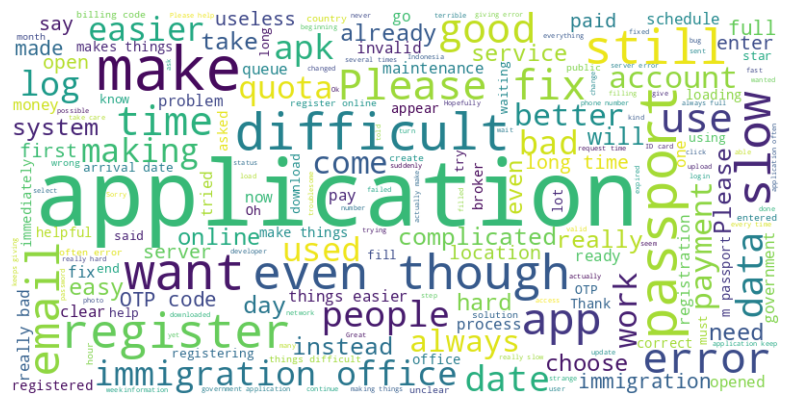

In [10]:
all_reviews = ' '.join(df['Translated_Review'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Cleaning Data

In [ ]:
nlp = spacy.load("en_core_web_sm")
stop_words_nltk = set(stopwords.words('english'))
stop_words_spacy = nlp.Defaults.stop_words
combined_stopwords = stop_words_nltk.union(stop_words_spacy)

df = df.dropna(subset=['Translated_Review'])

def clean_text(text):
    text = text.lower()
    words = text.split()
    filtered_words = [word for word in words if word not in combined_stopwords]
    cleaned_text = ' '.join(filtered_words)

    cleaned_text = cleaned_text.translate(str.maketrans('', '', string.punctuation))
    cleaned_text = re.sub(r'\d+', '', cleaned_text)
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

df['Cleaned_Review'] = df['Translated_Review'].apply(clean_text)
df[['Translated_Review', 'Cleaned_Review']].head()

<ipython-input-42-ba32debebe7b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cleaned_Review'] = df['Translated_Review'].apply(clean_text)


,Translated_Review,Cleaned_Review
0,"Can't even select location, the application is...",cant select location application suitable use
1,I can't open it... I've already filled in the ...,cant open it ive filled data exit application ...
2,"There is no help center, asked the admin to co...",help center asked admin continue help center o...
3,app.. please fix it again. the problem is that...,app fix again problem exits data invalid corre...
4,The account verification code is very slow to ...,account verification code slow sent boring dea...


In [ ]:
df

,Review,Rating,Date,Translated_Review,Cleaned_Review
0,"Pilih lokasi saja tidak bisa, aplikasi tidak l...",1,2024-10-24 15:24:03,"Can't even select location, the application is...",cant select location application suitable use
1,Sy punya ga bisa kebuka..udh isi data tau tau ...,1,2024-10-24 11:55:17,I can't open it... I've already filled in the ...,cant open it ive filled data exit application ...
2,"ga ada pusat bantuan, suru ke admin buat lanju...",2,2024-10-24 06:26:01,"There is no help center, asked the admin to co...",help center asked admin continue help center o...
3,app ny.. tolong di perbaiki lg. soal ny sering...,2,2024-10-24 06:23:13,app.. please fix it again. the problem is that...,app fix again problem exits data invalid corre...
4,Kode verifikasi akun nya sangat lambat di kiri...,1,2024-10-24 05:53:59,The account verification code is very slow to ...,account verification code slow sent boring dea...
...,...,...,...,...,...
14337,Mantabbbb,5,2022-01-04 02:08:13,Awesome,awesome
14338,Tidak ditemukan Kanim di lokasi anda,2,2021-12-31 12:07:17,No Kanim found in your location,kanim found location
14339,Lemot bgt pas milih lokasi pengambilan paspor ...,1,2021-12-31 08:32:04,It's really slow when choosing a passport pick...,slow choosing passport pickup location appear ...
14340,Aplikasi ini sangat membantu bagi saya yang me...,5,2021-12-31 02:59:30,This app is very helpful for me who needs a pa...,app helpful needs passport clearer procedure t...


In [ ]:
df.to_csv('cleaned_paspor_online_reviews.csv', index=False)

In [ ]:
df = pd.read_csv('cleaned_paspor_online_reviews.csv')
df = df.dropna(subset=['Cleaned_Review'])
df.reset_index(drop=True, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14264 entries, 0 to 14263
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review             14264 non-null  object
 1   Rating             14264 non-null  int64 
 2   Date               14264 non-null  object
 3   Translated_Review  14264 non-null  object
 4   Cleaned_Review     14264 non-null  object
dtypes: int64(1), object(4)
memory usage: 557.3+ KB


## Labeling Data

In [ ]:
# Label sentiment and extract polarity
def label_sentiment(text):
    blob = TextBlob(text)
    polarity = round(blob.sentiment.polarity, 5)
    if polarity > 0.1:
        sentiment = 'Positive'
    elif polarity < -0.1:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return sentiment, polarity

df[['Sentiment', 'Polarity']] = df['Cleaned_Review'].apply(lambda x: pd.Series(label_sentiment(x)))

In [ ]:
df['Sentiment'].value_counts()

df[['Cleaned_Review', 'Sentiment', 'Polarity']].head()

,Cleaned_Review,Sentiment,Polarity
0,cant select location application suitable use,Positive,0.55000
1,cant open it ive filled data exit application ...,Positive,0.20000
2,help center asked admin continue help center o...,Neutral,-0.06667
3,app fix again problem exits data invalid corre...,Neutral,0.07619
4,account verification code slow sent boring dea...,Negative,-0.65000


In [ ]:
df.to_csv('labeled_paspor_online_reviews.csv', index=False)

In [11]:
df = pd.read_csv('labeled_paspor_online_reviews.csv')

positive_reviews = df[df['Sentiment'] == 'Positive'].sample(100, random_state=42)
neutral_reviews = df[df['Sentiment'] == 'Neutral'].sample(100, random_state=42)
negative_reviews = df[df['Sentiment'] == 'Negative'].sample(100, random_state=42)

final_test_set = pd.concat([positive_reviews, neutral_reviews, negative_reviews])
final_test_set.reset_index(drop=True, inplace=True)
df = df.drop(final_test_set.index)
df.reset_index(drop=True, inplace=True)

final_test_set.to_csv("final_test_reviews.csv", index=False)
df.to_csv("train_reviews.csv", index=False)

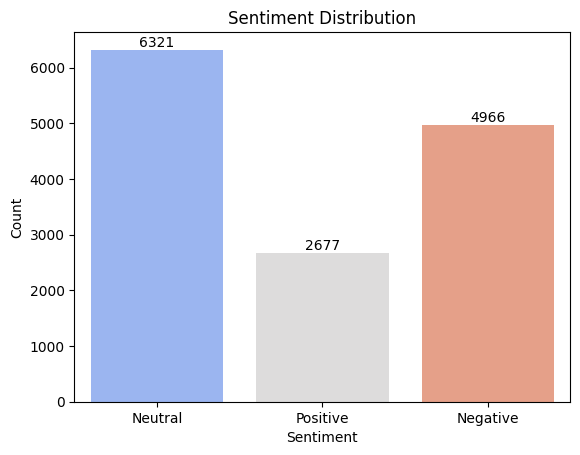

In [12]:
ax = sns.countplot(data=df, x='Sentiment', hue='Sentiment', palette='coolwarm')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height() + 5),
                ha='center', va='bottom')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13964 entries, 0 to 13963
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Review             13964 non-null  object 
 1   Rating             13964 non-null  int64  
 2   Date               13964 non-null  object 
 3   Translated_Review  13964 non-null  object 
 4   Cleaned_Review     13964 non-null  object 
 5   Sentiment          13964 non-null  object 
 6   Polarity           13964 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 763.8+ KB


In [ ]:
final_test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Review             300 non-null    object 
 1   Rating             300 non-null    int64  
 2   Date               300 non-null    object 
 3   Translated_Review  300 non-null    object 
 4   Cleaned_Review     300 non-null    object 
 5   Sentiment          300 non-null    object 
 6   Polarity           300 non-null    float64
dtypes: float64(1), int64(1), object(5)
memory usage: 16.5+ KB


# 2. Feature Extraction

## TF-IDF

In [ ]:
df_train = pd.read_csv('train_reviews.csv')
df_train = df_train.dropna(subset=['Cleaned_Review', 'Sentiment'])

X = df_train['Cleaned_Review']
y = df_train['Sentiment']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, 'label_encoder.joblib')

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=3,
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

## Word2Vec

In [ ]:
X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]

w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=2, min_count=1, sg=1)
w2v_model.save("word2vec_model.bin")

def get_average_vector(tokens, model):
    vectors = []
    for word in tokens:
        if word in model.wv:
            vectors.append(model.wv[word])
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_train_w2v = np.array([get_average_vector(text.split(), w2v_model) for text in X_train])
X_test_w2v = np.array([get_average_vector(text.split(), w2v_model) for text in X_test])

# 3. Training Model

## Machine Learning

### TF-IDF

In [ ]:
# Random Forest dengan TF-IDF
rf_model_tfidf = RandomForestClassifier(random_state=42)
rf_model_tfidf.fit(X_train_tfidf, y_train)

y_pred_rf_tfidf = rf_model_tfidf.predict(X_test_tfidf)
accuracy_rf_tfidf = accuracy_score(y_test, y_pred_rf_tfidf)

joblib.dump(rf_model_tfidf, 'rf_model_tfidf.joblib')
print(f"Akurasi Random Forest dengan TF-IDF: {accuracy_rf_tfidf:.3f}")

Akurasi Random Forest dengan TF-IDF: 0.835


In [ ]:
# SVM dengan TF-IDF
svm_model_tfidf = SVC(kernel='linear')
svm_model_tfidf.fit(X_train_tfidf, y_train)

y_pred_svm_tfidf = svm_model_tfidf.predict(X_test_tfidf)
accuracy_svm_tfidf = accuracy_score(y_test, y_pred_svm_tfidf)

joblib.dump(svm_model_tfidf, 'svm_model_tfidf.joblib')
print(f"Akurasi SVM dengan TF-IDF: {accuracy_svm_tfidf:.3f}")

Akurasi SVM dengan TF-IDF: 0.864


In [ ]:
# XGBoost dengan TF-IDF
xgb_model_tfidf = XGBClassifier(eval_metric='mlogloss')
xgb_model_tfidf.fit(X_train_tfidf, y_train)

y_pred_xgb_tfidf = xgb_model_tfidf.predict(X_test_tfidf)
accuracy_xgb_tfidf = accuracy_score(y_test, y_pred_xgb_tfidf)

joblib.dump(xgb_model_tfidf, 'xgb_model_tfidf.joblib')
print(f"Akurasi XGBoost dengan TF-IDF: {accuracy_xgb_tfidf:.3f}")

Akurasi XGBoost dengan TF-IDF: 0.837


### Word2Vec

In [ ]:
# Random Forest dengan Word2Vec
rf_model_w2v = RandomForestClassifier(random_state=42)
rf_model_w2v.fit(X_train_w2v, y_train)

y_pred_rf_w2v = rf_model_w2v.predict(X_test_w2v)
accuracy_rf_w2v = accuracy_score(y_test, y_pred_rf_w2v)

joblib.dump(rf_model_w2v, 'rf_model_w2v.joblib')
print(f"Akurasi Random Forest dengan Word2Vec: {accuracy_rf_w2v:.3f}")

Akurasi Random Forest dengan Word2Vec: 0.648


In [ ]:
# SVM dengan Word2Vec
svm_model_w2v = SVC(kernel='linear')
svm_model_w2v.fit(X_train_w2v, y_train)

y_pred_svm_w2v = svm_model_w2v.predict(X_test_w2v)
accuracy_svm_w2v = accuracy_score(y_test, y_pred_svm_w2v)

joblib.dump(svm_model_w2v, 'svm_model_w2v.joblib')
print(f"Akurasi SVM dengan TF-IDF: {accuracy_svm_w2v:.3f}")

Akurasi SVM dengan TF-IDF: 0.601


In [ ]:
# XGBoost dengan Word2Vec
xgb_model_w2v = XGBClassifier(eval_metric='mlogloss')
xgb_model_w2v.fit(X_train_w2v, y_train)

y_pred_xgb_w2v = xgb_model_w2v.predict(X_test_w2v)
accuracy_xgb_w2v = accuracy_score(y_test, y_pred_xgb_w2v)

joblib.dump(xgb_model_w2v, 'xgb_model_w2v.joblib')
print(f"Akurasi XGBoost dengan Word2Vec: {accuracy_xgb_w2v:.3f}")

Akurasi XGBoost dengan Word2Vec: 0.658


## Deep Learning

### Load Model

In [ ]:
df_dl = df_train[['Translated_Review', 'Sentiment']]

label_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
df_dl['Sentiment'] = df_dl['Sentiment'].map(label_mapping)

train_df_dl, test_df_dl = train_test_split(df_dl, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

<ipython-input-12-dabcb817f207>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dl['Sentiment'] = df_dl['Sentiment'].map(label_mapping)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenize

In [ ]:
# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['Translated_Review'],
                     padding='max_length',
                     truncation=True,
                     max_length=128)

train_dataset = Dataset.from_pandas(train_df_dl)
test_dataset = Dataset.from_pandas(test_df_dl)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'Sentiment'])
train_dataset = train_dataset.map(lambda x: {'labels': x['Sentiment']})
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'Sentiment'])
test_dataset = test_dataset.map(lambda x: {'labels': x['Sentiment']})

Map:   0%|          | 0/11171 [00:00<?, ? examples/s]

Map:   0%|          | 0/2793 [00:00<?, ? examples/s]

Map:   0%|          | 0/11171 [00:00<?, ? examples/s]

Map:   0%|          | 0/2793 [00:00<?, ? examples/s]

### Training

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    run_name="my_training_run"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.414500,0.308921,0.896169,0.896048,0.896042,0.896169
2,0.259700,0.258534,0.919799,0.919461,0.920436,0.919799
3,0.171400,0.310606,0.929825,0.929649,0.930840,0.929825


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.414500,0.308921,0.896169,0.896048,0.896042,0.896169
2,0.259700,0.258534,0.919799,0.919461,0.920436,0.919799
3,0.171400,0.310606,0.929825,0.929649,0.930840,0.929825
4,0.085700,0.345105,0.935195,0.935020,0.935337,0.935195


TrainOutput(global_step=5588, training_loss=0.24850572136870092, metrics={'train_runtime': 1480.6543, 'train_samples_per_second': 30.179, 'train_steps_per_second': 3.774, 'total_flos': 2939239989439488.0, 'train_loss': 0.24850572136870092, 'epoch': 4.0})

In [ ]:
# Save model dan tokenizer
model.save_pretrained('./my_model')
tokenizer.save_pretrained('./my_model')

('./my_model/tokenizer_config.json',
 './my_model/special_tokens_map.json',
 './my_model/vocab.txt',
 './my_model/added_tokens.json')

# 4. Evaluation

## Machine Learning

### TF-IDF

In [ ]:
new_df = pd.read_csv('final_test_reviews.csv')
new_df = new_df.dropna(subset=['Translated_Review'])

label_encoder = joblib.load('label_encoder.joblib')
new_df['Sentiment'] = label_encoder.transform(new_df['Sentiment'])
X_new = new_df['Translated_Review']

tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')
rf_model_tfidf = joblib.load('rf_model_tfidf.joblib')
svm_model_tfidf = joblib.load('svm_model_tfidf.joblib')
xgb_model_tfidf = joblib.load('xgb_model_tfidf.joblib')

X_new_tfidf = tfidf_vectorizer.transform(X_new)

y_pred_rf_tfidf = rf_model_tfidf.predict(X_new_tfidf)
y_pred_svm_tfidf = svm_model_tfidf.predict(X_new_tfidf)
y_pred_xgb_tfidf = xgb_model_tfidf.predict(X_new_tfidf)

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Classification Report for Random Forest (TF-IDF):
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       100
           1       0.93      0.93      0.93       100
           2       0.96      0.93      0.94       100

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



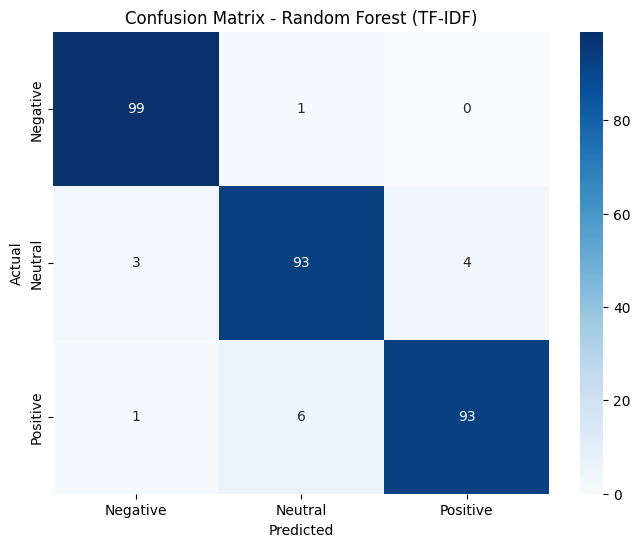

In [ ]:
print("Classification Report for Random Forest (TF-IDF):")
print(classification_report(new_df['Sentiment'], y_pred_rf_tfidf))
plot_confusion_matrix(new_df['Sentiment'], y_pred_rf_tfidf, "Random Forest (TF-IDF)")

Classification Report for SVM (TF-IDF):
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       100
           1       0.85      0.93      0.89       100
           2       0.98      0.88      0.93       100

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



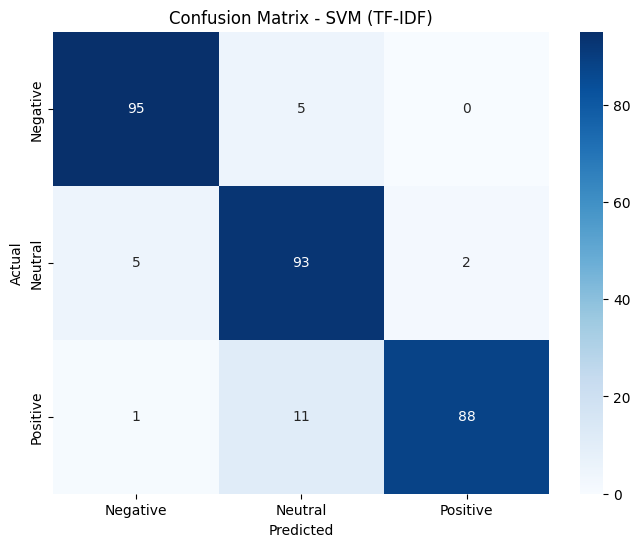

In [ ]:
print("Classification Report for SVM (TF-IDF):")
print(classification_report(new_df['Sentiment'], y_pred_svm_tfidf))
plot_confusion_matrix(new_df['Sentiment'], y_pred_svm_tfidf, "SVM (TF-IDF)")

Classification Report for XGBoost (TF-IDF):
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       100
           1       0.82      0.93      0.87       100
           2       0.96      0.87      0.91       100

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



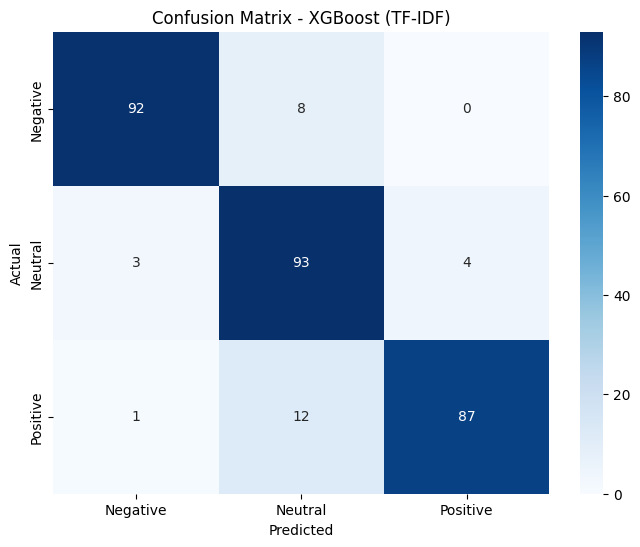

In [ ]:
print("Classification Report for XGBoost (TF-IDF):")
print(classification_report(new_df['Sentiment'], y_pred_xgb_tfidf))
plot_confusion_matrix(new_df['Sentiment'], y_pred_xgb_tfidf, "XGBoost (TF-IDF)")

### Word2Vec

In [ ]:
w2v_model = Word2Vec.load("word2vec_model.bin")

X_new_tokens = [text.split() for text in X_new]

def get_average_vector(tokens, model):
    vectors = []
    for word in tokens:
        if word in model.wv:
            vectors.append(model.wv[word])
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_new_w2v = np.array([get_average_vector(text.split(), w2v_model) for text in X_new])

rf_model_w2v = joblib.load('rf_model_w2v.joblib')
svm_model_w2v = joblib.load('svm_model_w2v.joblib')
xgb_model_w2v = joblib.load('xgb_model_w2v.joblib')

y_pred_rf_w2v = rf_model_w2v.predict(X_new_w2v)
y_pred_svm_w2v = svm_model_w2v.predict(X_new_w2v)
y_pred_xgb_w2v = xgb_model_w2v.predict(X_new_w2v)

Classification Report for Random Forest (Word2Vec):
              precision    recall  f1-score   support

           0       0.55      0.36      0.44       100
           1       0.40      0.82      0.54       100
           2       0.84      0.27      0.41       100

    accuracy                           0.48       300
   macro avg       0.60      0.48      0.46       300
weighted avg       0.60      0.48      0.46       300



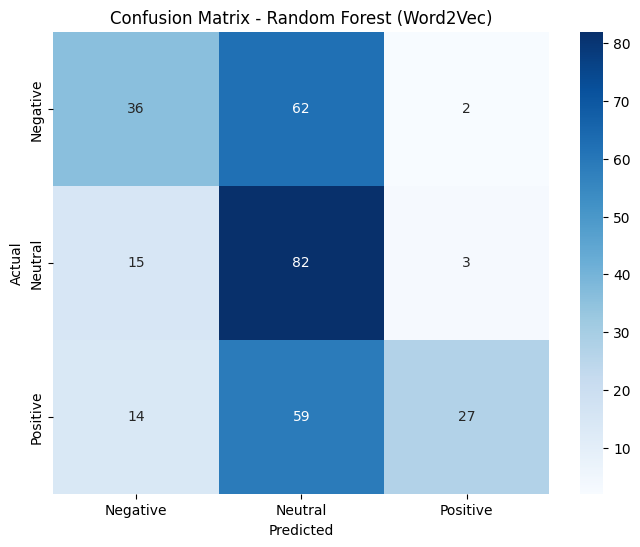

In [ ]:
print("Classification Report for Random Forest (Word2Vec):")
print(classification_report(new_df['Sentiment'], y_pred_rf_w2v))
plot_confusion_matrix(new_df['Sentiment'], y_pred_rf_w2v, "Random Forest (Word2Vec)")

Classification Report for SVM (Word2Vec):
              precision    recall  f1-score   support

           0       0.67      0.20      0.31       100
           1       0.34      0.90      0.49       100
           2       1.00      0.05      0.10       100

    accuracy                           0.38       300
   macro avg       0.67      0.38      0.30       300
weighted avg       0.67      0.38      0.30       300



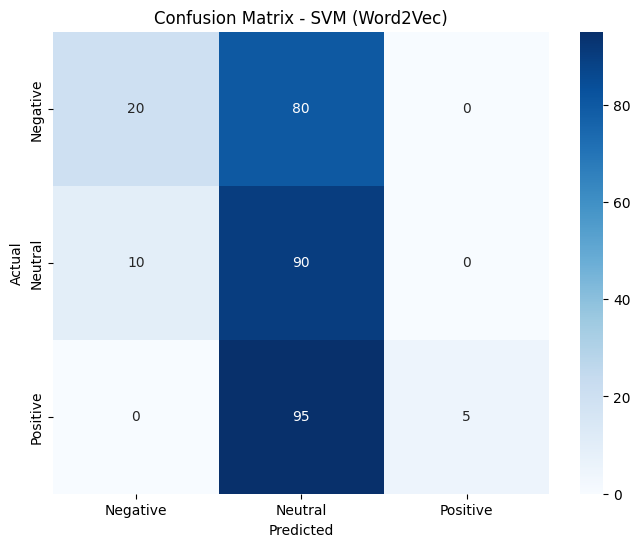

In [ ]:
print("Classification Report for SVM (Word2Vec):")
print(classification_report(new_df['Sentiment'], y_pred_svm_w2v))
plot_confusion_matrix(new_df['Sentiment'], y_pred_svm_w2v, "SVM (Word2Vec)")

Classification Report for XGBoost (Word2Vec):
              precision    recall  f1-score   support

           0       0.52      0.34      0.41       100
           1       0.39      0.66      0.49       100
           2       0.53      0.34      0.41       100

    accuracy                           0.45       300
   macro avg       0.48      0.45      0.44       300
weighted avg       0.48      0.45      0.44       300



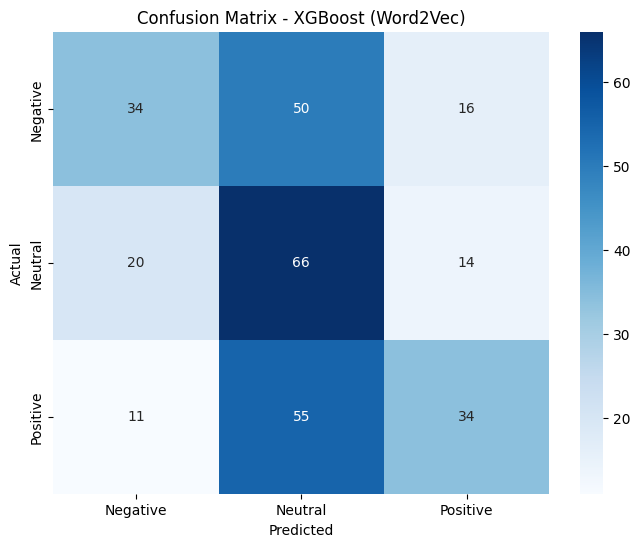

In [ ]:
print("Classification Report for XGBoost (Word2Vec):")
print(classification_report(new_df['Sentiment'], y_pred_xgb_w2v))
plot_confusion_matrix(new_df['Sentiment'], y_pred_xgb_w2v, "XGBoost (Word2Vec)")

## Deep Learning

In [ ]:
new_df = pd.read_csv('final_test_reviews.csv')
new_df = new_df.dropna(subset=['Translated_Review'])
new_df = new_df[['Translated_Review', 'Sentiment']]

# Tokenize the new dataset
new_dataset = Dataset.from_pandas(new_df)
new_dataset = new_dataset.map(tokenize, batched=True)

# Set format for PyTorch compatibility
new_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
predictions = trainer.predict(new_dataset)
pred_labels = predictions.predictions.argmax(-1)

if 'Sentiment' in new_df.columns:
    true_labels = new_df['Sentiment'].map(label_mapping).values
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    acc = accuracy_score(true_labels, pred_labels)

    print(f"Accuracy: {acc}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

Accuracy: 0.9833333333333333
F1 Score: 0.9832807282546575
Precision: 0.9834593222815308
Recall: 0.9833333333333333


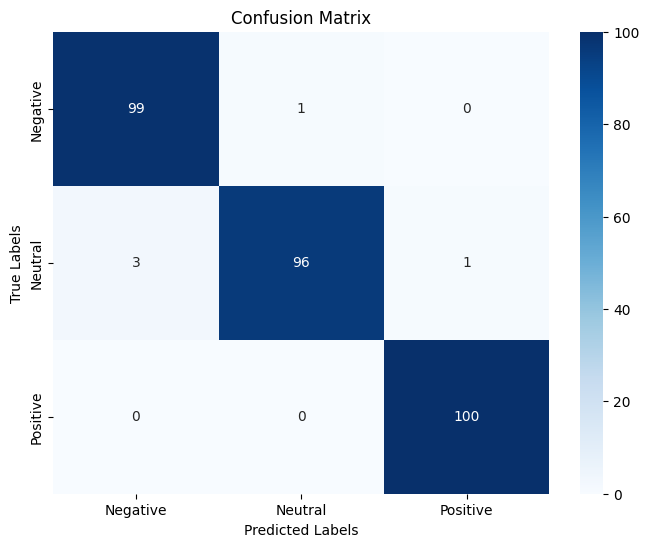

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Predict new reviews

In [ ]:
def predict_ml_models(input_text):
    rf_model = joblib.load('rf_model_tfidf.joblib')
    svm_model = joblib.load('svm_model_tfidf.joblib')
    xgb_model = joblib.load('xgb_model_tfidf.joblib')
    tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')
    label_encoder = joblib.load('label_encoder.joblib')

    input_tfidf = tfidf_vectorizer.transform([input_text])

    rf_pred = rf_model.predict(input_tfidf)
    svm_pred = svm_model.predict(input_tfidf)
    xgb_pred = xgb_model.predict(input_tfidf)

    rf_label = label_encoder.inverse_transform(rf_pred)[0]
    svm_label = label_encoder.inverse_transform(svm_pred)[0]
    xgb_label = label_encoder.inverse_transform(xgb_pred)[0]

    return rf_label, svm_label, xgb_label

label_mapping = {2: 'Positive', 1: 'Neutral', 0: 'Negative'}

def predict_dl_model(input_text):
    tokenizer = BertTokenizer.from_pretrained('./my_model')
    model = BertForSequenceClassification.from_pretrained('./my_model')

    model.eval()

    inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = logits.argmax().item()

    predicted_class = label_mapping[predicted_class_id]

    return predicted_class

In [ ]:
new_input = "the app often closes itself during use"

rf_result, svm_result, xgb_result = predict_ml_models(new_input)
print(f"Random Forest Prediction: {rf_result}")
print(f"SVM Prediction: {svm_result}")
print(f"XGBoost Prediction: {xgb_result}")

Random Forest Prediction: Neutral
SVM Prediction: Neutral
XGBoost Prediction: Neutral


In [ ]:
prediction = predict_dl_model(new_input)
print(f"Bert Prediction: {prediction}")

Bert Prediction: Neutral
